In [157]:
print("let's  start ")
import sys 
print(sys.version)


let's  start 
3.11.4 | packaged by Anaconda, Inc. | (main, Jul  5 2023, 13:38:37) [MSC v.1916 64 bit (AMD64)]


In [158]:
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.neighbors import KernelDensity
import scipy 
from scipy.ndimage import filters
from scipy.stats import norm
from scipy.interpolate import interp1d
from scipy import interp
from IPython import display

In [159]:
#Global vars
thresold = 0.97

In [170]:
def normal_pdf(p,mu,sigma):
    return (1.0/(sigma*np.sqrt(2*np.pi)))*np.exp(-((p-mu)**2)/(2*sigma**2))
def biv_normal(data, mean, covariance):
    dtmnt= np.linalg.det(covariance)
    inverse = np.linalg.inv(covariance)
    norm = (2 * np.pi) ** (-data.shape[1] / 2) * dtmnt** -0.5
    diff = data - mean
    exponent = -0.5 * np.einsum('ij,ij->i', diff, np.dot(inverse, diff.T).T)
    prob_density = norm * np.exp(exponent)
    return prob_density
def gaussian_kernel(gd, dp):
    hd = np.histogram(dp, bins=len(gd), range=(gd.min(), gd.max()))[0]
    nd = hd / float(hd.sum())

def gaussian_kde(grid, points, sigma=0.001):
    density_matrix = norm.pdf(grid[:, np.newaxis], loc=points, scale=sigma)
    density = density_matrix.sum(axis=1)
    normalized_density = density / density.sum()
    return normalized_density
def pWasserstein(pdf1,pdf2,p):
    # f : transport map
    # phi : disp potential 
    # p wasserstein distance
    offset=1e-7
    pdf1=pdf1+offset 
    pdf2=pdf2+offset
    pdf1=pdf1/pdf1.sum() # sumof masses are to be 1 always so
    pdf2=pdf2/pdf2.sum()
    CDF1=np.cumsum(pdf1) # Calculate the CDFs
    CDF2=np.cumsum(pdf2)
    inds=np.asarray(range(len(pdf1))) 
    datpts=np.linspace(0,1,len(pdf1))
    Xpdf1 = np.interp(datpts,CDF1, inds)
    Xpdf2 = np.interp(datpts,CDF2, inds)
    u = np.interp(inds,Xpdf1,Xpdf1-Xpdf2) # u(x)
    f = inds-u
    phi= np.cumsum(u/(len(pdf1))) # Integrate u(x) to obtain phi(x)
    phi-=phi.mean() # Subtract the mean of phi to account for the unknown constant
    Wp=(((abs(u)**p)*pdf1).mean())**(1.0/p)
    return f,phi, Wp 

In [171]:
def gmm1d(x,mu,sigma,alpha):
    out=np.zeros_like(x)
    for i in range(len(mu)):
        out+=alpha[i]*normal_pdf(x,mu[i],sigma[i])
    return out/out.sum()
def radon_transform(L, d):
    T=np.zeros((L, d))
    t=np.random.rand(1, d)
    T[0,:]=t/ np.sqrt((t**2).sum())
    for i in range(1, L):
        t=np.random.randn(1, d)
        t=t / np.sqrt((t**2).sum())
        m=abs(np.matmul(T[:i, :], t.T)).max()
        while m > thresold:
            t=np.random.randn(1, d)
            t=t / np.sqrt((t**2).sum())
            m=abs(np.matmul(T[:i, :], t.T)).max()
        T[i, :] = t
    return T


In [172]:
N = 1000
alphas = [.3 , 0.3 , 0.4]
sigmas = [2.,2.5,1.5]
means  = [-5. , 0. , 5.]
pts = np.linspace(-15,15,1000)
egmm = gmm1d(pts,mu=means,sigma=sigmas,alpha=alphas)
samples = np.zeros((N,))
labels = np.zeros((N,))
for n in range(N):
    label = np.random.choice(np.arange(len(alphas)), p=alphas)
    samples[n]=np.random.normal(loc=means[label], scale=sigmas[label])
    labels[n] = label
kde=KernelDensity(bandwidth=.5).fit(samples[:,np.newaxis])

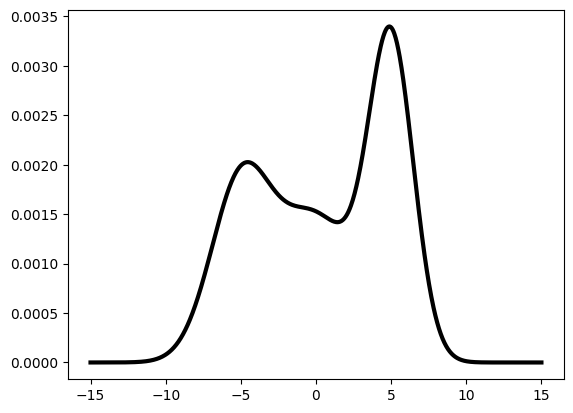

In [173]:
plt.plot(pts,egmm,'k',linewidth=3)
plt.show()

C:\Users\Srinjoy Som\AppData\Local\Temp\ipykernel_2320\3594170666.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontsize=16)


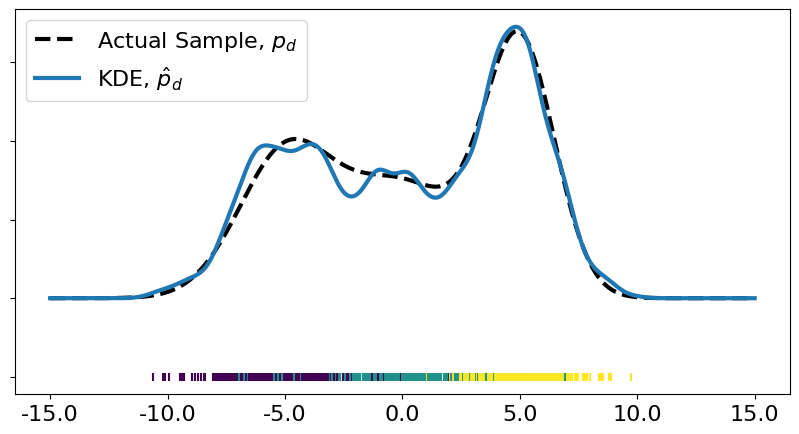

In [174]:
fig, ax = plt.subplots(figsize=(10, 5))
kde_probs = np.exp(kde.score_samples(pts[:, np.newaxis]))
kde_probs /= kde_probs.sum()
ax.plot(pts, egmm, 'k--', linewidth=3, label=r'Actual Sample, $p_d$')
ax.plot(pts, kde_probs, linewidth=3, label=r'KDE, $\hat{p}_d$')
ax.scatter(samples, -0.001 * np.ones_like(samples), marker='|', c=labels)
ax.legend(fontsize=16)
ax.set_xticklabels(ax.get_xticks(), fontsize=16)
ax.set_yticklabels([])
plt.show()

In [175]:
def dev_mu(t,mu,sigma):
    f=(1.0/(sigma*np.sqrt(2*np.pi)))*np.exp(-((t-mu)**2)/(2*sigma**2))
    return ((t-mu)/(sigma**2))*f

In [176]:
def dev_sig(t,mu,sigma):
    f=(1.0/(sigma*np.sqrt(2*np.pi)))*np.exp(-((t-mu)**2)/(2*sigma**2))
    return (f/sigma)*((((t-mu)**2)/(sigma**2))-1.)

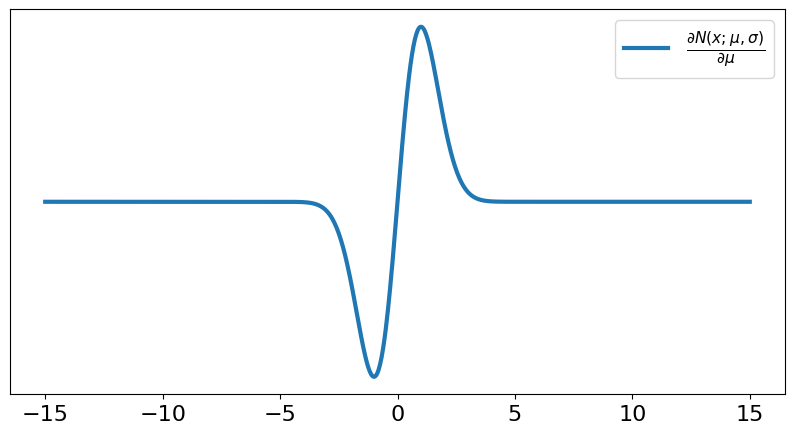

In [177]:
temp=dev_mu(pts,0,1)
fig=plt.figure(figsize=(10,5))
plt.plot(pts,temp,linewidth=3,label=r'$\frac{\partial N(x;\mu,\sigma)}{\partial \mu}$')
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks([])
plt.legend(fontsize=16)
plt.show()

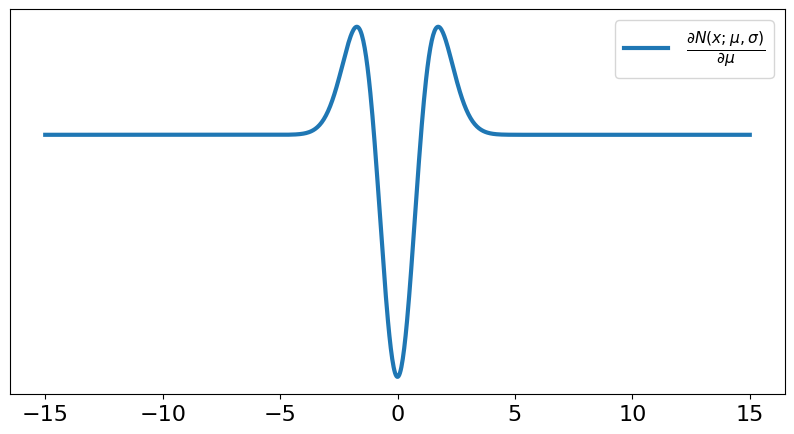

In [178]:
temp=dev_sig(pts,0,1)
fig=plt.figure(figsize=(10,5))
plt.plot(pts,temp,linewidth=3,label=r'$\frac{\partial N(x;\mu,\sigma)}{\partial \mu}$')
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks([])
plt.legend(fontsize=16)
plt.show()

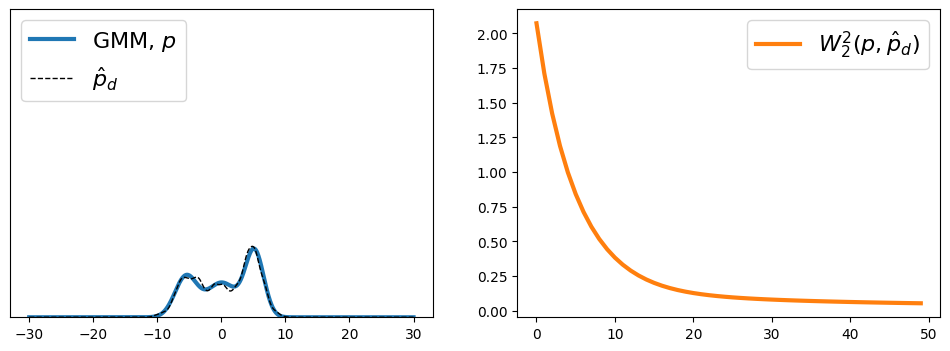

[0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 4.94065646e-324 5.18768928e-322 5.04935090e-320 4.86336977e-318
 4.61717355e-316 4.32064548e-314 3.98524202e-312 3.62321748e-310
 3.24689121e-308 2.86797066e-306 2.49698139e-304 2.14283898e-302
 1.81258092e-300 1.51125902e-298 1.24197838e-296 1.00605750e-294
 8.03276758e-293 6.32180699e-291 4.90400492e-289 3.74967990e-287
 2.82599328e-285 2.09933472e-283 1.53718410e-281 1.10943973e-279
 7.89251065e-278 5.53426909e-276 3.82506659e-274 2.60586169e-272
 1.74983604e-270 1.15818246e-268 7.55597033e-267 4.85889078e-265
 3.07976560e-263 1.92411853e-261 1.18489431e-259 7.19218816e-258
 4.30304709e-256 2.53760949e-254 1.47505127e-252 8.45129131e-251
 4.77279369e-249 2.65678179e-247 1.45771540e-245 7.88357549e-244
 4.20249643e-242 2.20813239e-240 1.14360619e-238 5.83796541e-237
 2.93751553e-235 1.45690911e-233 7.12226911e-232 3.43192614e-230
 1.63001319e-228 7.63093823e-227 3.52126241e-225 1.60159416e-223
 7.18026038e-222 3.172937

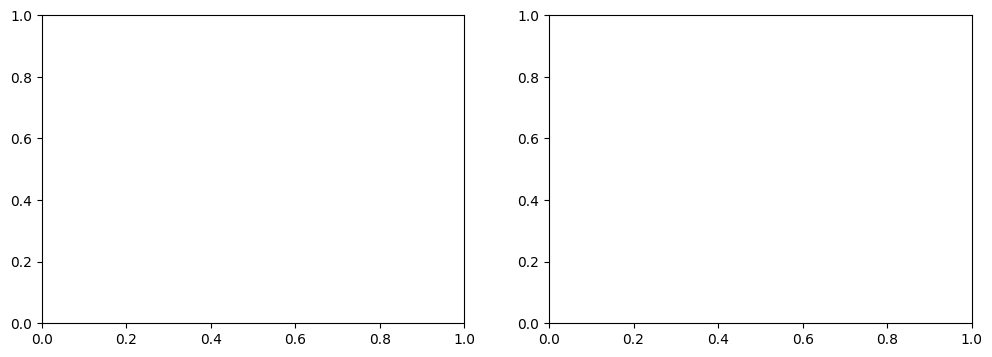

In [181]:
import time
i=0
t=np.linspace(-30,30,1000)
dt=t[1]-t[0]

kde=KernelDensity(bandwidth=.5).fit(samples[:,np.newaxis])
lr=100
lra=.1

alphas = [0.3,0.3,0.4]
sigmas = [2,2,2]
means  = [-10.,0,10]

loss=[]
K= len(means)

q=np.exp(kde.score_samples(t[:,np.newaxis]))
q/=q.sum()

p=gmm1d(t,means,sigmas,alphas)

fig,ax=plt.subplots(1,2,figsize=(12,4))
for iteration in range(50):    
    
    # Calculate the Wasserstein distance and transport map
    f,phi,Wp=pWasserstein(p,q,2)
    loss.append(Wp)
    u=dt*(f-np.arange(p.shape[0]))
    
    # Plot the results
    ax[0].plot(t,p,linewidth=3,label=r'GMM, $p$')
    ax[0].plot(t,q,'k--',linewidth=1,label=r'$\hat{p}_d$')
    ax[0].legend(fontsize=16,loc='upper left')
    ax[0].set_ylim(0,0.03)
    ax[0].set_yticks([])
    
    ax[1].plot(np.asarray(loss),c='C1',linewidth=3,label=r'$W_2^2(p,\hat{p}_d)$')
    ax[1].legend(fontsize=16,loc='upper right')
    display.clear_output(wait=True)
    display.display(plt.gcf()) 
    time.sleep(1e-3)           
    for i in range(2):
        ax[i].clear()
    
    # Calculate the gradients and update parameters with gradient descent
    for i in range(K):        
        dmu = alphas[i]*((phi)*dev_mu(t,means[i],sigmas[i])).mean()
        dsigma = alphas[i]*((phi)*dev_sig(t,means[i],sigmas[i])).mean()
        dalpha = ((phi)*normal_pdf(t,means[i],sigmas[i])).mean()

        means[i] = means[i]-lr*dmu
        sigmas[i] = max(sigmas[i]-lr*dsigma,0.)
        alphas[i] = max(alphas[i]-lra*dalpha,0.)
    
    alpha_sum=np.sum(alphas)
    alphas= [a/alpha_sum for a in alphas]    
    
    # Update the gmm
    p=gmm1d(t,means,sigmas,alphas)
    print(q)
    
    